 <center> 
        <h1> EDIPI Training Event 1&2, November 2021 </h1>
        <h2> Introductory exercises: data analysis with xarray and scipy </h2>
 </center>

# Imports

First cell in notebook should always contain all necessary imports

In [1]:
import numpy as np
import xarray as xr
import scipy.stats as stats
from matplotlib import pyplot as plt

# Load the dataset and take a look at the contents
The dataset contains a single variable called 'tmax' with time coordinate 'time'.

The 'tmax' variable is ERA5 daily-maximum surface temperature from the Pacific Northwest area of the USA for the period 1950-2021.

In [2]:
ds = xr.open_dataset('itmax_era5_index.nc')
ds

<xarray.Dataset>
Dimensions:  (time: 26298)
Coordinates:
  * time     (time) datetime64[ns] 1950-01-01 1950-01-02 ... 2021-12-31
Data variables:
    tmax     (time) float32 ...
Attributes: (12/21)
    title:                      spatial statistic of "ERA5 reanalysis, https:...
    description:                tmax era5 index
    scripturl01:                https://climexp.knmi.nl/get_index.cgi?email=$...
    minimal_valid_fraction:      30.00
    file:                       ERA5/era5_tmax_daily_na_extended.nc
    cdi:                        Climate Data Interface version 1.9.10 (https:...
    ...                         ...
    cdo:                        Climate Data Operators version 1.9.10 (https:...
    ave_region:                 lon= -123.125 -118.875, lat=   44.875   52.125
    comment:                    
    scripturl02:                https://climexp.knmi.nl/dat2nc.cgi?id=$id&sta...
    history:                     2021-11-03 18:34:46 bin/dat2nc data/itmax_er...
    Conventions:                CF-1.0

# Extract the tmax data array and plot it

Clearly, the summer 2021 of was an extreme event, you can read about it [here](https://www.worldweatherattribution.org/western-north-american-extreme-heat-virtually-impossible-without-human-caused-climate-change/)

In [3]:
tx = ds['tmax'] # tx now contains the tmax data

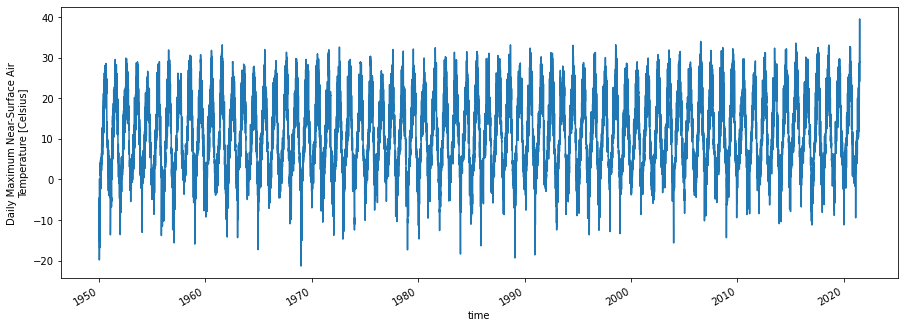

In [4]:
plt.figure(figsize=(15,5))
tx.plot();

# The properties of time
The 'time' coordinate is a datetime64 object, which provides lots of powerful functionality in xarray, see [here](http://xarray.pydata.org/en/stable/user-guide/time-series.html)

In particular, the .dt method gives access to a lot of information: “year”, “month”, “day”, “hour”, “minute”, “second”, “dayofyear”, “week”, “dayofweek”, “weekday”, “quarter” and "season". 

In [5]:
dates = ds['time'].sel(time = ['1950-01-01', '1966-07-14', '2001-09-11']) # can select specific dates as strings
dates

<xarray.DataArray 'time' (time: 3)>
array(['1950-01-01T00:00:00.000000000', '1966-07-14T00:00:00.000000000',
       '2001-09-11T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1950-01-01 1966-07-14 2001-09-11
Attributes:
    standard_name:  time
    long_name:      time
    axis:           T

In [6]:
dates.dt.dayofyear # the day of year at those dates

<xarray.DataArray 'dayofyear' (time: 3)>
array([  1, 195, 254])
Coordinates:
  * time     (time) datetime64[ns] 1950-01-01 1966-07-14 2001-09-11

In [7]:
dates.dt.season # the season at those dates

<xarray.DataArray 'season' (time: 3)>
array(['DJF', 'JJA', 'SON'], dtype='<U3')
Coordinates:
  * time     (time) datetime64[ns] 1950-01-01 1966-07-14 2001-09-11

# Exercises

## Compute the mean, median and 99th percentile temperature
Use the xarray .mean and [.quantile](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.quantile.html) functions

In [46]:
print('mean: %4.1f' % tx.mean(dim='time'))
print('median: %4.1f' % tx.quantile(0.5, dim='time'))
print('99th percentile: %4.1f' % tx.quantile(0.99, dim='time') )

mean: 11.1
median: 10.2
99th percentile: 29.9


## Compute the mean summer (May-Sep) temperature for the years 2011-2020

Use [.sel](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.sel.html) to select the years 2011-2020

Use [.where](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.where.html) to filter out non-summer days 

Use [.coarsen](https://xarray.pydata.org/en/stable/generated/xarray.DataArray.coarsen.html) to take means over each the summer of each year

In [9]:
# select all data in the time range specified by slice
tx_2011_2020 = tx.sel(time = slice('2011-01-01','2020-12-31')) 

# filter data -- replace all data with dates outside May-Sep with nan
tx_2011_2020_summer = tx_2011_2020.where(tx['time'].dt.month.isin([5,6,7,8,9]))

# coarsen data into 365 day chunks and average over each chunk. 
#Nans do not contribute to mean, so the result is the May-Sep mean for each year
tx_2011_2020_summer_mean = tx_2011_2020_summer.coarsen(time=365,boundary='trim').mean()

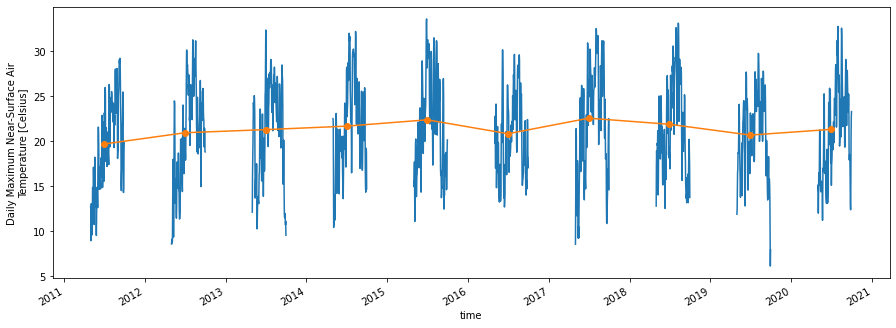

In [10]:
plt.figure(figsize=(15,5))
tx_2011_2020_summer.plot()
tx_2011_2020_summer_mean.plot.line(marker='o');

## Compute a smoothed seasonal cycle

Use [.groupby](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.groupby.html) to group data by day of year and average over all years -- this gives a "raw" seasonal cycle

Apply [.rolling](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.rolling.html) to the raw seasonal cycle to compute a 31-day running-mean smoothed seasonal cycle; you will need to use [.pad](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.pad.html) with mode='wrap' to extend the raw seasonal cycle periodically, so the running mean window doesn't run out of data at the beginning and end 

In [11]:
# daily seasonal cycle
tx_sc = tx.groupby(tx['time'].dt.dayofyear).mean()

# smooth seasonal cyle with moving average over window of specified width
window = 31
pad = int(window/2)
tx_sc_smooth = tx_sc.pad(dayofyear=(pad,pad), mode='wrap').rolling(dayofyear=window,center=True).mean().dropna(dim='dayofyear')

# remove seasonal cycle from data
tx_nosc = tx.groupby('time.dayofyear') - tx_sc_smooth

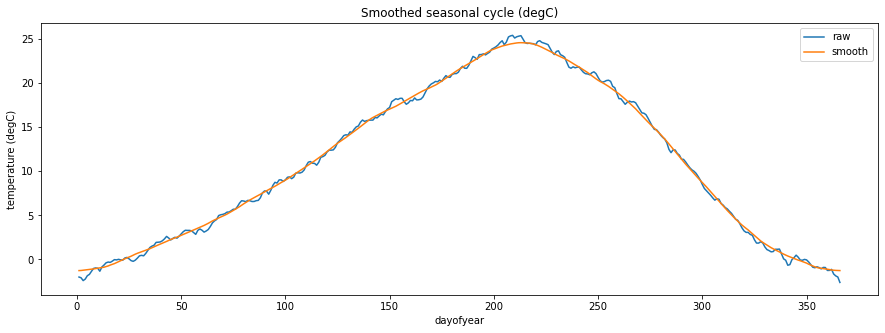

In [12]:
plt.figure(figsize=(15,5))
tx_sc.plot()
tx_sc_smooth.plot()
plt.legend(['raw','smooth'])
plt.title('Smoothed seasonal cycle (degC)');
plt.ylabel('temperature (degC)');

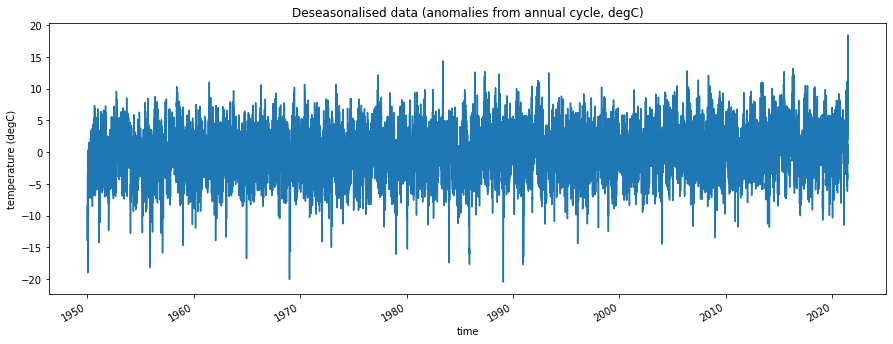

In [13]:
plt.figure(figsize=(15,5))
tx_nosc.plot()
plt.title('Deseasonalised data (anomalies from annual cycle, degC)');
plt.ylabel('temperature (degC)');

## Extract annual block maxima (i.e. the maximum temperature for each year in the dataset)

Use [.groupby](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.groupby.html) to group data by year and extract the maximum value for each year

In [14]:
tx_bm = tx.groupby(tx['time'].dt.year).max()

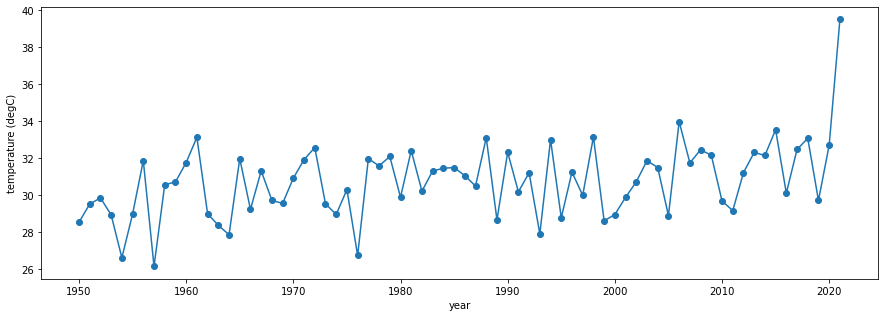

In [15]:
plt.figure(figsize=(15,5))
tx_bm.plot.line(marker='o');
plt.ylabel('temperature (degC)');

## Compute the linear time trend in the annual maxima

A linear time trend is just a linear regression of the data onto time.

Compute the trend in the annual block maxima calculated above using [stats.linregress](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html)

In [16]:
# note that the time axis of tx_bm is no longer called 'time', it's called 'year'
r = stats.linregress(tx_bm['year'], tx_bm)
trend = r.intercept + r.slope * tx_bm['year']
tx_bm_detr = tx_bm - trend + tx_bm.mean()

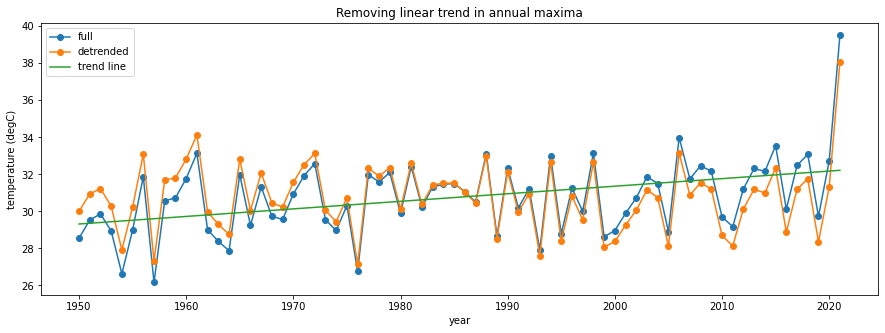

In [17]:
plt.figure(figsize=(15,5))
tx_bm.plot.line(marker='o')
tx_bm_detr.plot.line(marker='o')
trend.plot.line()
plt.legend(['full','detrended','trend line'])
plt.title('Removing linear trend in annual maxima');
plt.ylabel('temperature (degC)');

## Estimating the probability density function (PDF)
The PDF is interpreted as "in a given year, a the temperature will have a value $\ell$ contined in a bin ($\ell$,$\ell+d\ell$) with probability $p \, d\ell$", where $p$ is the PDF.

The PDF for a given dataset can be estimated 2 ways:
1. parametrically: assume the data follows a given distribution function, and fit the parameters
2. non-parametrically: compute a histogram

<b>Exercise</b>: 

Apply both these approaches to the annual block maxima:
1. Use [stats.genextreme.fit](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.genextreme.html) to fit a generalized extreme value (GEV) distribution to the block maxima, <b>leaving out the extreme data point for 2021</b>
2. Generate a "frozen" random variate object by calling stats.genextreme with the fitted parameters: rv = stats.genextreme(params)
3. Compute the PDF using rv.pdf
4. Compare to histogram, computed using the xarray .plot.hist function 

In [18]:
# fit a GEV distribution
shape, location, scale = stats.genextreme.fit( tx_bm.sel(year=slice('1950','2020')) )
print(shape, location, scale)

# produce "frozen" random variate for the fitted distribution
rv = stats.genextreme(shape, location, scale)

# set up a dummy tx axis called tx_p which spans from the 0.001 percentile to the 0.999 percentile of the fitted distribution
tx_min = rv.ppf(0.001)
tx_max = rv.ppf(0.999)
tx_p = np.linspace(tx_min, tx_max, 100)

# compute the PDF
p = rv.pdf(tx_p)

0.44344893039383315 30.16768201460574 1.8451298419501154


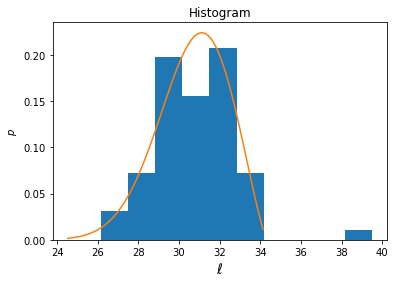

In [20]:
tx_bm.plot.hist(bins=10, density=True)
plt.plot(tx_p, p)
plt.ylabel('$p$')
plt.xlabel('$\ell$',fontsize=14);

## Estimating the cumulative distribution function (CDF)
The CDF is just the integral of the PDF. It can be interpreted as "in a given year, the temperature will stay below level $\ell$ with probability $P(\ell)$", where $P$ is the CDF.

Alternatively, once can consider the function $1-P$ (sometimes called the survival function); then interpretation is "in a given year, the temperature will *exceed* $\ell$  with probability $1-P(\ell)$"

Again, the CDF can be estimated parametrically (via a fit, as above), or non-parametrically directly from the data.

The simplest non-parametric estimator for the CDF is to rank the data points in ascending order and assume that the CDF increases by 1/N for each data point, where N is total number of years in sample. More accurate assumptions are described [here](https://edx.hydrolearn.org/courses/course-v1:HydroLearn+HydroLearn410+2019_S2/courseware/cd43c81fa55944d4ad7d5bd9aabc8837/6bdb39cb4f1847a4afeab59c37706570/3?activate_block_id=block-v1%3AHydroLearn%2BHydroLearn410%2B2019_S2%2Btype%40vertical%2Bblock%40a03085271bac412ebbcc7a25e12b081a).

<b>Exercise</b>: 
1. Use the .sortby function to rank the annual block maxima in ascending order
2. Create a P array which increases from just above 0 to just below 1 in N even steps, as described in the link above
3. Plot the two against one another; this is the non-parametric CDF
4. Compute and plot the parametric CDF using rv.cdf with the "frozen" rv computed in the previous exercise

In [21]:
# Non-parametric CDF estimator
N = len(tx_bm) # number of data points
tx_np = tx_bm.sortby(tx_bm, ascending=True) 
a = 0.5 # this is the Hazen estimator
P_np = (np.linspace(1, N, N) - a)/ (N + 1 - 2*a)

# Parametric estimator
P_p = rv.cdf(tx_p)

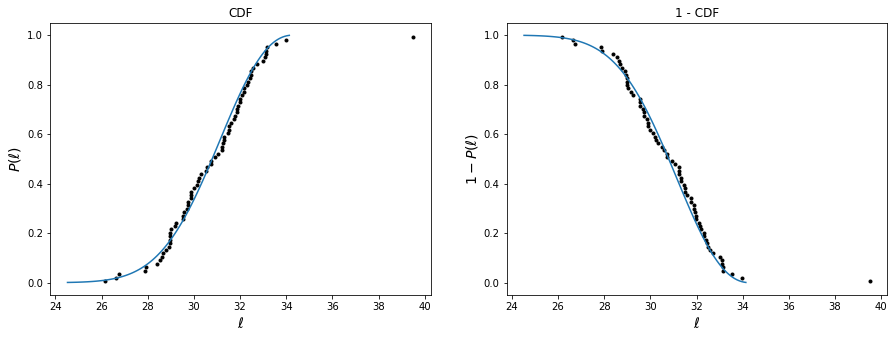

In [22]:
fig,axes = plt.subplots(1,2,figsize=(15,5))

ax=axes[0]
ax.plot(tx_np, P_np, 'k.')
ax.plot(tx_p, P_p)
ax.set_xlabel('$\ell$',fontsize=14)
ax.set_ylabel('$P(\ell$)',fontsize=14)
ax.set_title('CDF')

ax=axes[1]
ax.plot(tx_np, 1 - P_np, 'k.')
ax.plot(tx_p, 1 - P_p)
ax.set_xlabel('$\ell$',fontsize=14)
ax.set_ylabel('$1-P(\ell$)',fontsize=14)
ax.set_title('1 - CDF');

## Return level plot

The <b>return period</b> $r$ is defined as the number of years you expect to wait in order to see the temperature exceeding a certain level $\ell$.

You can also think of return period as the number of years you need to wait in order for the probability of exceeding $\ell$ to be just equal to 1, assuming all years are independent:

$r \ (1-P(\ell)) = 1$

so

$ r = \frac{1}{1-P(\ell)}$

A return level plot is just a modified form of the 1-CDF plot, with the temperatures plotted on the y axis (instead of the x axis) and with $r = 1/(1-P)$ on the x axis.

<b>Exercise</b>: 

Plot the parametric and non-parametric return level estimators. Use a <b>logarithmic</b> x axis.

In [23]:
# non-parametric return periods
r_np = 1 / (1 - P_np)

# parametric return periods
r_p = 1 / (1 - P_p)

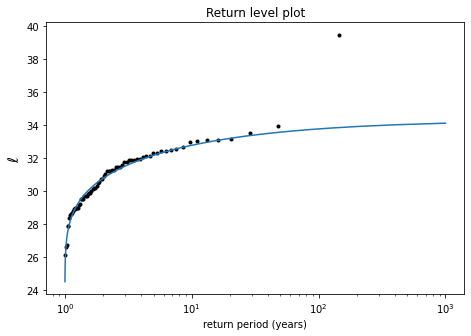

In [24]:
plt.figure(figsize=(7.5,5))
plt.semilogx(r_np, tx_np, 'k.')
plt.semilogx(r_p, tx_p)
plt.ylabel('$\ell$',fontsize=14)
plt.xlabel('return period (years)');
plt.title('Return level plot');

## Bootstrap method to determine uncertainty in fit

<b>Exercise</b>: To get an estimate of the uncertainty in the estimates, do the following:
1. Generate 1000 synthetic data samples by resampling the block maxima with replacement (use the np.random.choice function)
2. Fit a GEV to each of the samples
3. For each fit, compute the return level for a given set of return periods
4. Compute the upper and lower percentiles for the return levels at each return period

In [25]:
def bootstrap_ci(original_sample):

    Nsamples = 1000 # no. of samples in bootstrap
    Nrp = 50        # no. of return periods 

    r = np.linspace(10, 1000, Nrp) # the return periods at which to compute confidence interval
    P = 1 - 1/r                     # the corresponding probabilities

    data = np.zeros((Nrp, Nsamples)) # array to hold bootstrap samples
    for i in range(Nsamples):
        sample = np.random.choice(original_sample, size=len(original_sample), replace=True) # resample with replacement
        rv = stats.genextreme( *stats.genextreme.fit(sample) ) # fit GEV to new sample 
        data[:,i] = rv.ppf(P) # get quantiles for given probs
    ci = np.percentile(data, (2.5, 97.5), axis=1) # 95% confidence interval
    return r, ci

In [26]:
# perform bootstrap 
r_boot, ci = bootstrap_ci(tx_bm[:-1])

/Users/rca/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2492: RuntimeWarning: invalid value encountered in subtract
  -pex2+logpex2-logex2)


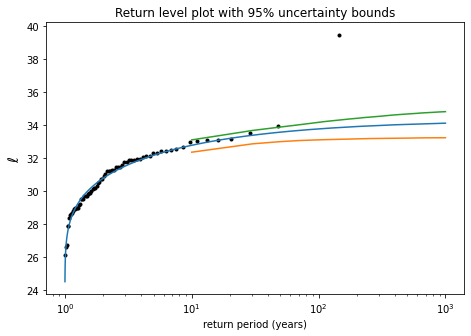

In [27]:
plt.figure(figsize=(7.5,5))
plt.semilogx(r_np, tx_np, 'k.')
plt.semilogx(r_p, tx_p)
plt.semilogx(r_boot, ci[0], r_boot, ci[1])
plt.ylabel('$\ell$',fontsize=14)
plt.xlabel('return period (years)');
plt.title('Return level plot with 95% uncertainty bounds');

# TODO Peak over threshold
compute 98%le threshold
extract POT
fit GPD

## Peaks over threshold

In [28]:
x_pot = x.where(x>1.3).dropna(dim='time')
xpot.plot.line(ls='none',marker='.')

NameError: name 'x' is not defined